In [47]:
import dask_awkward as dak
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
load_path = "/depot/cms/users/yun79/results/stage1/test_full2/f1_0"
sample = "vbf_powheg"
# sample = "ggh_powheg"
# sample = "dy_M-100To200"
# sample = "data_A"
full_load_path = f"/depot/cms/users/yun79/results/stage1/test_validation_bigV2/2018/f1_0/{sample}/*/*.parquet"
# full_load_path = f"/depot/cms/users/yun79/results/stage1/test_validation_bigV2/2018/f0_1/{sample}/*/*.parquet"

df_new = dak.from_parquet(full_load_path) 
# region_cut = (df_new.h_peak | df_new.h_sidebands)
# df_new = df_new[region_cut]

In [57]:
! ls /depot/cms/users/yun79/results/stage1/test_validation_bigV2/2018/f1_0

ggh_powheg  vbf_powheg


In [46]:
! ls /depot/cms/users/yun79/results/stage1/test_validation_bigV2/2018/f1_0/

data_A	ggh_powheg  vbf_powheg


In [9]:
! ls /depot/cms/users/yun79/hmm/test_validation_bigV1/stage1_output/2018/

ggh_powheg  vbf_powheg


In [48]:
full_load_path = f"/depot/cms/users/yun79/hmm/test_validation_bigV1/stage1_output/2018/{sample}/*.parquet"
import dask.dataframe as dd
import pandas as pd
# df = dd.from_pandas(pd.DataFrame(), npartitions=1)
df_old = dd.read_parquet(full_load_path)
# region = df_old.region.compute()

In [49]:
binning_map = {
    "pt" : [25, 300, 50],
    "eta" : [-5, 5, 30],
    "phi" : [-3.1415, 3.1415, 101],
    "mass" : [0, 150, 100],
}
variables = ["mu1_pt","mu1_eta", "mu1_phi", 
             "jet1_pt", "jet1_eta", "jet1_phi"
            ]
weights_old = df_old["weights"].compute()
weights_new = ak.to_numpy((df_new["weights"]/df_new["fraction"]).compute())
if "ggh" in sample:
    print("ggh in sample!")
    nnlops_full_load_path = f'/depot/cms/users/yun79/results/stage1/test_full2/2018/f1_0/{sample}/*/nnlops/wgt.parquet'
    nnlops_wgts = ak.from_parquet(nnlops_full_load_path)["nnlops_wgt"]
    weights_new = weights_new*nnlops_wgts



In [10]:
print(weights_new[0])
print(weights_old.iloc[0])

10.000000082778637
1.0


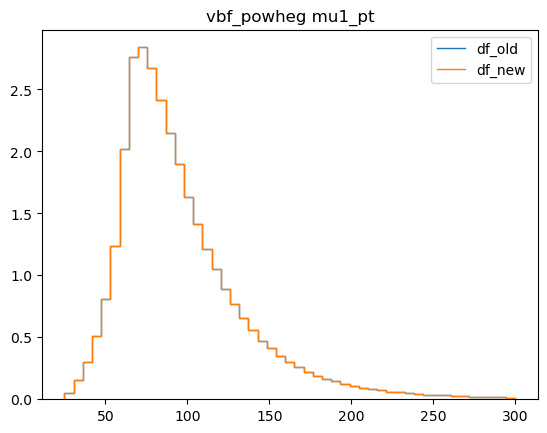

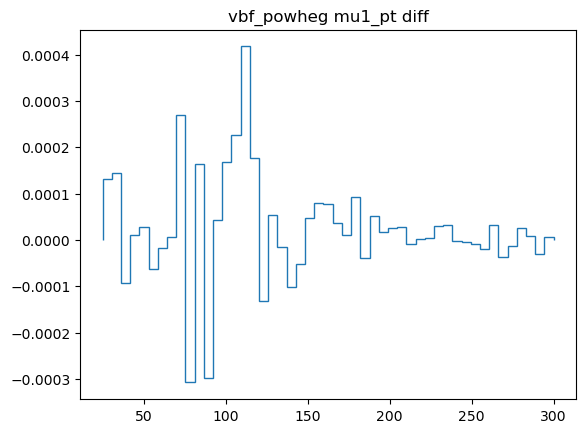

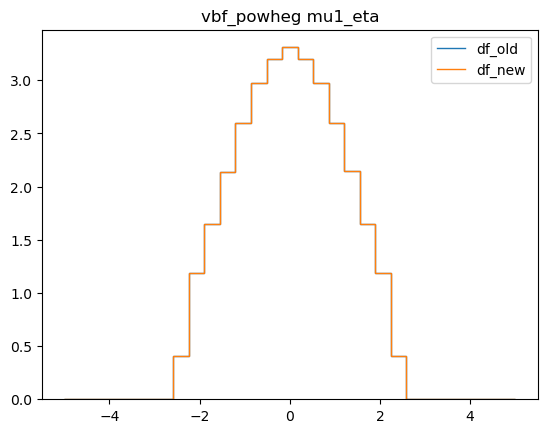

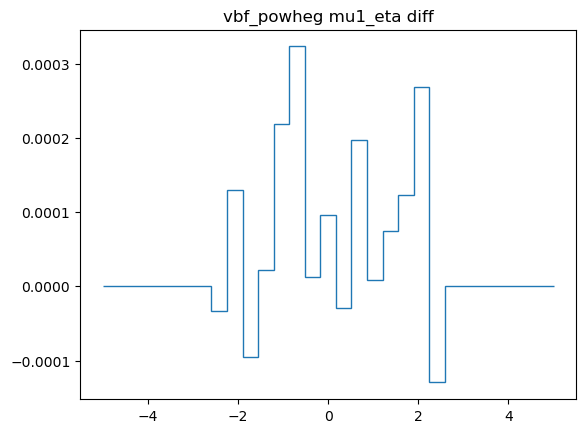

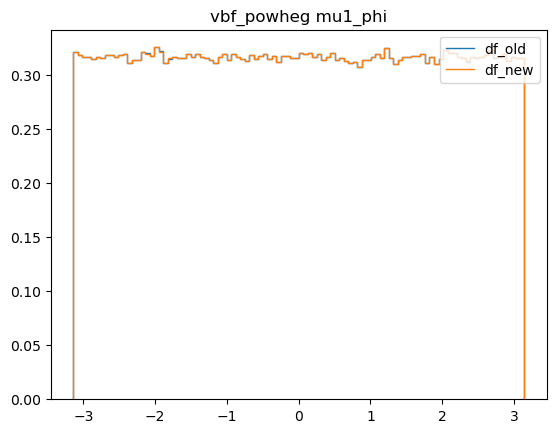

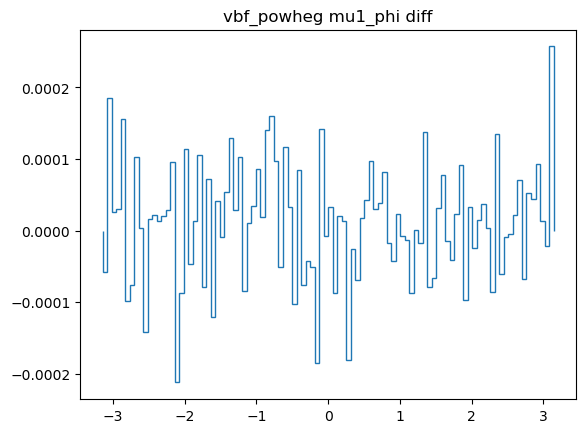

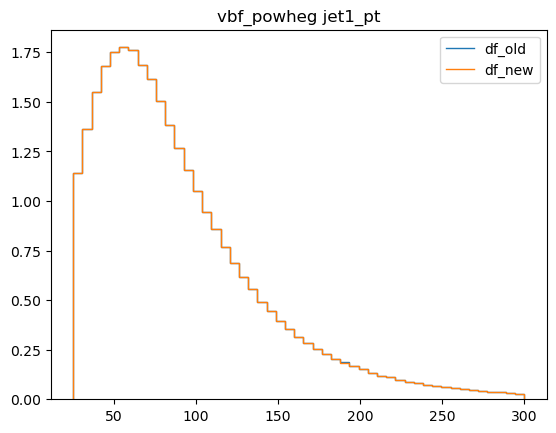

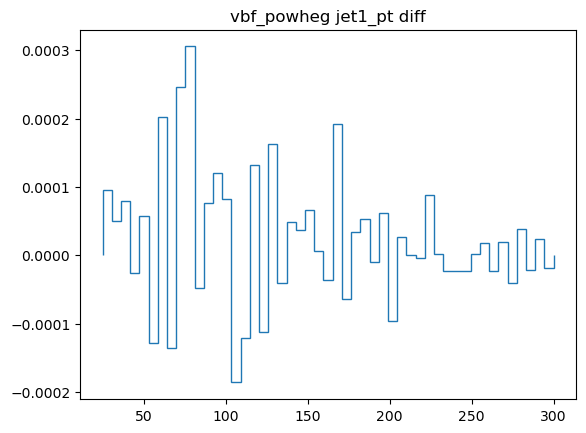

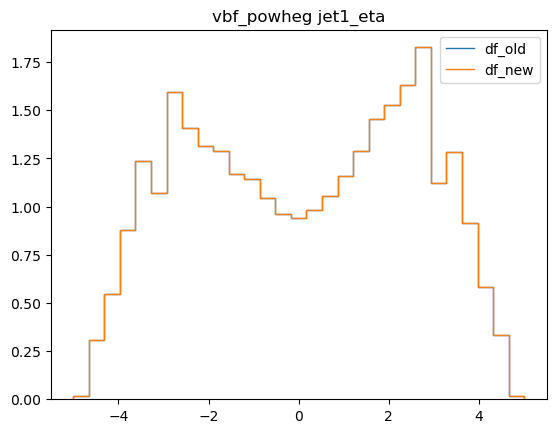

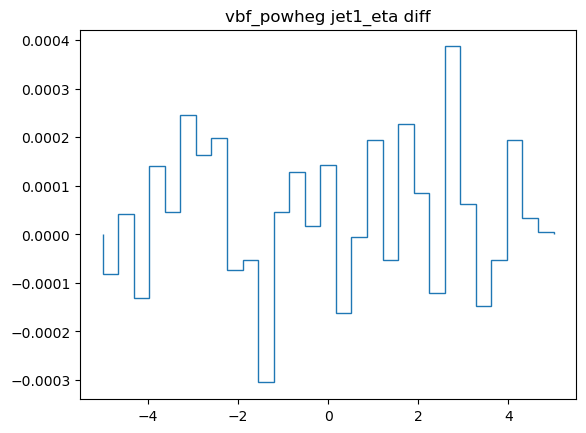

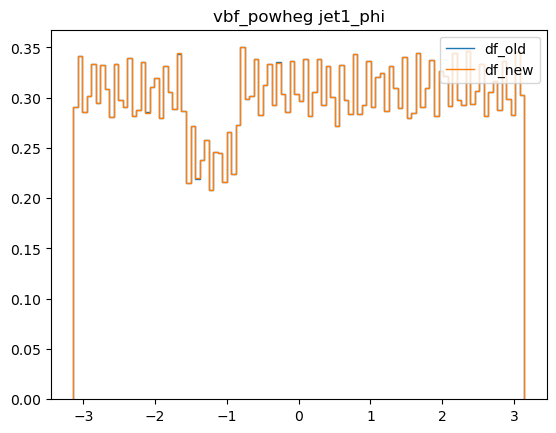

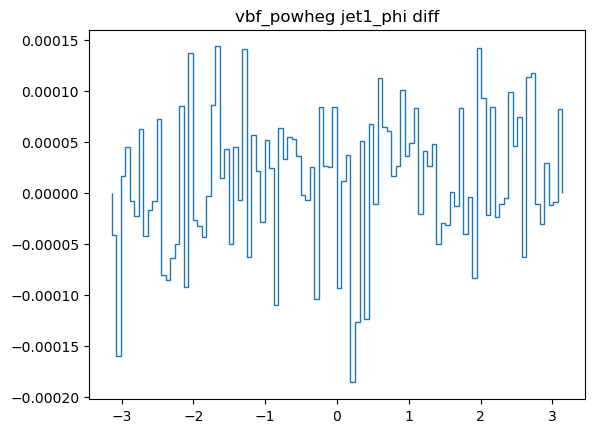

In [50]:
for var in variables:
    kin = var.split("_")[-1]
    # binning = np.linspace(*[25, 300, 50])
    binning = np.linspace(*binning_map[kin])
    # old_len = ak.num(df_old["mu1_pt"].compute(), axis=0)
    # new_len = ak.num(df_new["mu1_pt"].compute(), axis=0)
    # new_weights = np.ones(new_len)
    # new_weights = new_weights*old_len/new_len
    hist_old, edges = np.histogram(df_old[var].compute(), bins=binning ,weights=weights_old)
    # hist_old, edges = np.histogram(df_old[var+"_nominal"].compute(), bins=binning )
    
    # hist_new, _= np.histogram(df_new[region_cut][var].compute(), bins=binning , weights=new_weights)
    hist_new, _= np.histogram(df_new[var].compute(), bins=binning ,weights=weights_new)
    
    plt.stairs(hist_old, edges, label = "df_old")
    plt.stairs(hist_new, edges, label = "df_new")
    plt.legend(loc="upper right")
    plt.title(f"{sample} {var}")
    plt.show()
    plt.stairs((hist_new-hist_old), edges)
    plt.title(f"{sample} {var}"+" diff")
    plt.show()

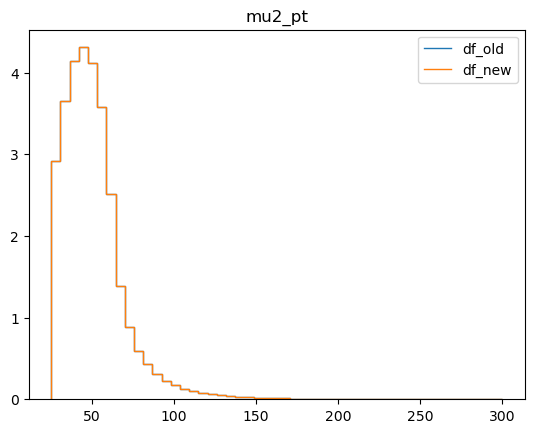

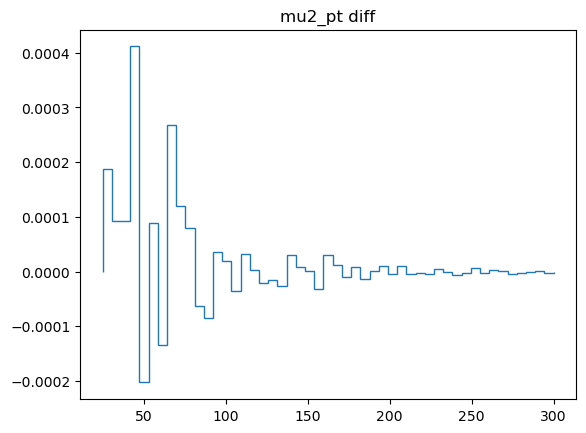

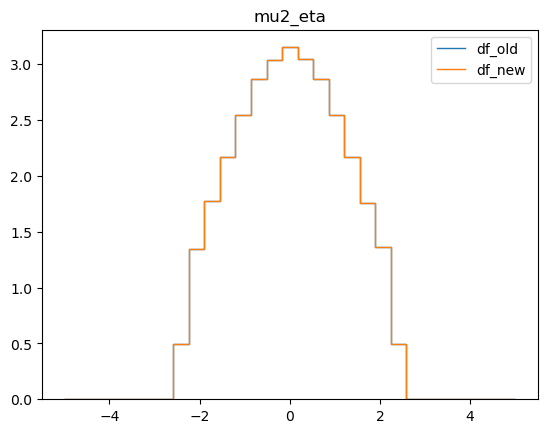

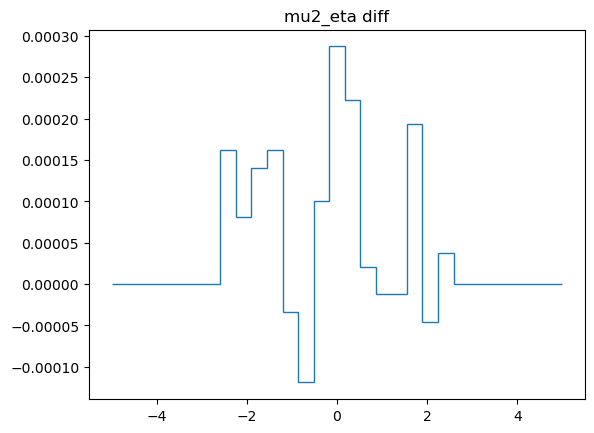

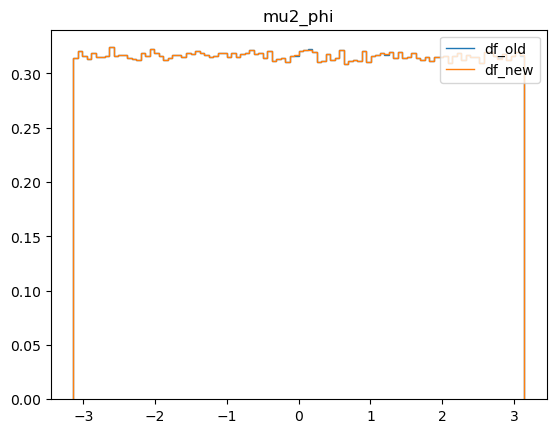

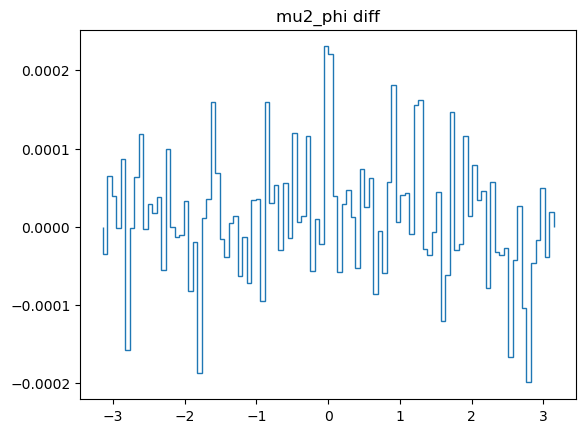

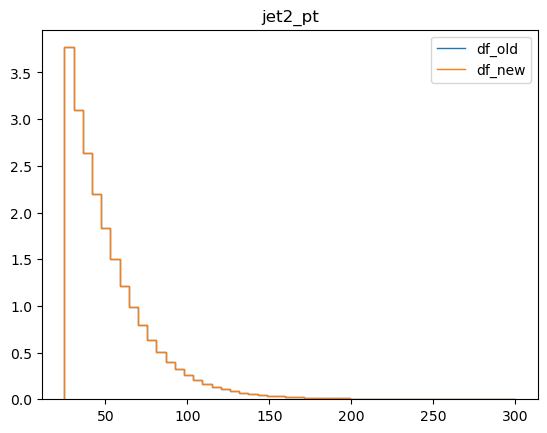

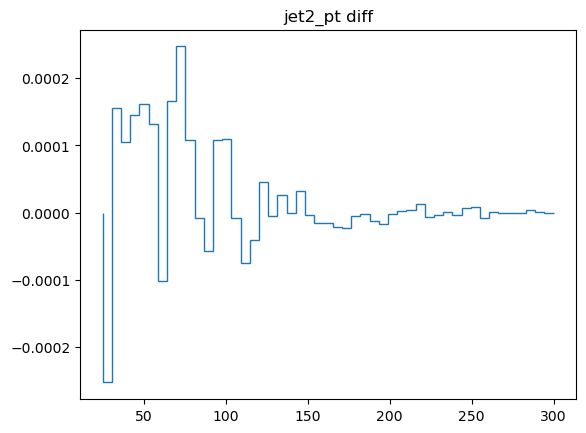

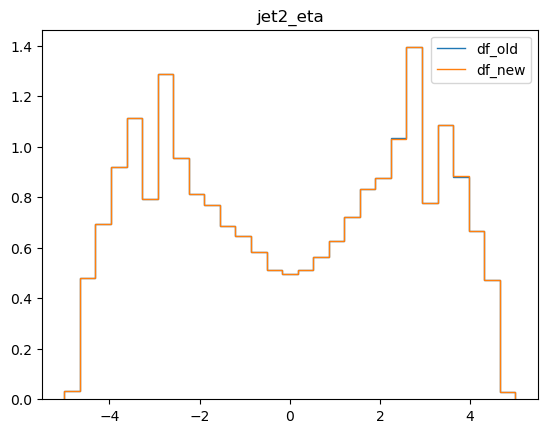

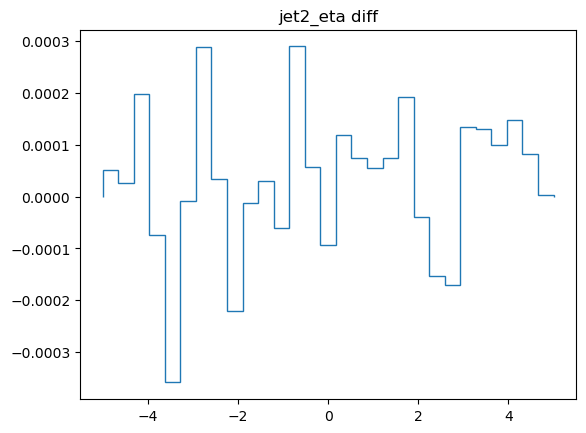

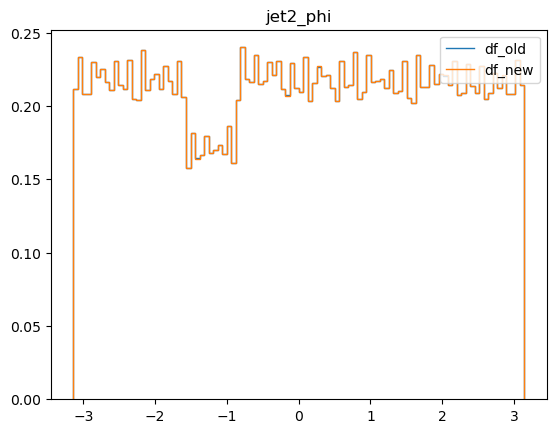

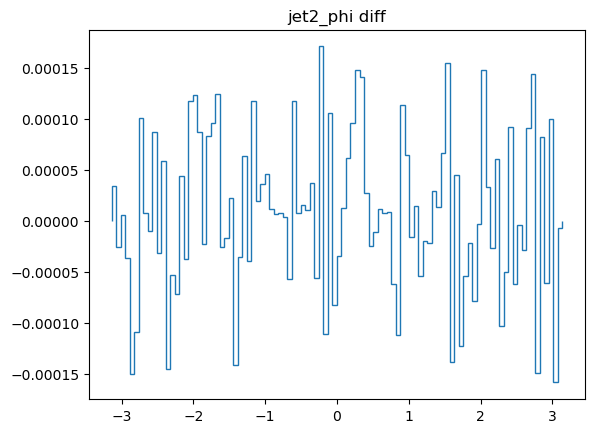

In [51]:
"""
For mu2, special condition is needed bc when there's only one muon, mu2==mu1 in copperhead
"""
# var = "mu1_pt"
# var = "dimuon_mass"
# var = "jet1_pt"
# variables = ["mu1_pt", "mu2_pt", "dimuon_mass"]
variables = ["mu2_pt","mu2_eta", "mu2_phi", 
             # "jet2_mass", 
             "jet2_pt", "jet2_eta", "jet2_phi"
            ]
    
for var in variables:
    kin = var.split("_")[-1]
    # binning = np.linspace(*[25, 300, 50])
    binning = np.linspace(*binning_map[kin])
    # the way copperheadV1 defines mu2 is the muon with the lowest pt, thus the
    # only way to make copperheadV1 and copperheadV2 same is to ensure nmuons ==2
    # if 'mu' in var:
    #     nvars_new = df_new["nmuons"].compute()
    #     nvars_old = df_old["nmuons"].compute()
    # else:
    #     nvars_new = df_new["njets"].compute()
    #     nvars_old = df_old["njets"].compute()
    # hist_old, edges = np.histogram(df_old[nvars_old ==2][var].compute(), bins=binning , weights=weights_old[nvars_old ==2])
    # hist_new, _= np.histogram(df_new[nvars_new ==2][var].compute(), bins=binning , weights=weights_new[nvars_new ==2])
    hist_old, edges = np.histogram(df_old[var].compute(), bins=binning , weights=weights_old)
    hist_new, _= np.histogram(df_new[var].compute(), bins=binning , weights=weights_new)
    
    
    plt.stairs(hist_old, edges, label = "df_old")
    plt.stairs(hist_new, edges, label = "df_new")
    plt.legend(loc="upper right")
    plt.title(var)
    plt.show()
    plt.stairs((hist_new-hist_old), edges)
    plt.title(var+" diff")
    plt.show()

In [19]:
import dask_awkward as dak
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
load_path = "/depot/cms/users/yun79/results/stage1/test_full2/f1_0"
# sample = "vbf_powheg"
# sample = "ggh_powheg"
# sample = "dy_M-100To200"
sample = "data_A"
full_load_path_p30 = f"/depot/cms/users/yun79/results/stage1/test_validation_bigV2_2/2018/f0_2999999975166409/{sample}/*/*.parquet"
full_load_path_p10 = f"/depot/cms/users/yun79/results/stage1/test_validation_bigV2/2018/f0_1/{sample}/*/*.parquet"

df_new_p30 = dak.from_parquet(full_load_path_p30) 
df_new_p10 = dak.from_parquet(full_load_path_p10) 

In [20]:
# !  /depot/cms/users/yun79/results/stage1/test_validation_bigV2/2018/f0_2999999975166409/data_A

In [21]:
# for i in range(1,27):
#     full_load_path_p30 = f"/depot/cms/users/yun79/results/stage1/test_validation_bigV2/2018/f0_2999999975166409/{sample}/{i}/*.parquet"
#     df_new_p30 = dak.from_parquet(full_load_path_p30) 
#     print(i)
#     print(df_new_p30.weights.compute())

In [22]:
weights_new_p30 = ak.to_numpy((df_new_p30["weights"]/df_new_p30["fraction"]).compute())
weights_new_p10 = ak.to_numpy((df_new_p10["weights"]/df_new_p10["fraction"]).compute())
# if "ggh" in sample:
#     print("ggh in sample!")
#     nnlops_full_load_path = f'/depot/cms/users/yun79/results/stage1/test_full2/2018/f1_0/{sample}/*/nnlops/wgt.parquet'
#     nnlops_wgts = ak.from_parquet(nnlops_full_load_path)["nnlops_wgt"]
#     weights_new = weights_new*nnlops_wgts
# print(weights_new_p30)
binning_map = {
    "pt" : [25, 300, 50],
    "eta" : [-5, 5, 30],
    "phi" : [-3.1415, 3.1415, 101],
    "mass" : [0, 150, 100],
}
variables = ["mu1_pt","mu1_eta", "mu1_phi", 
             "jet1_pt", "jet1_eta", "jet1_phi"
            ]


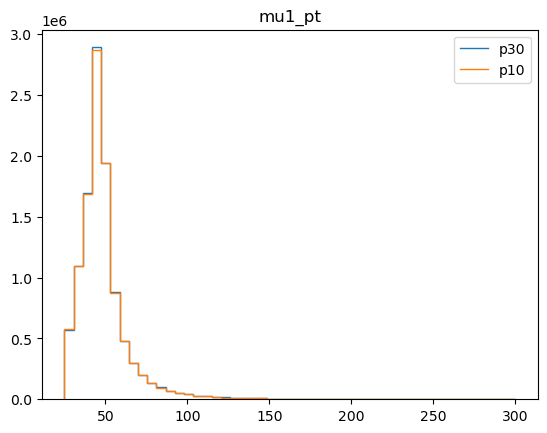

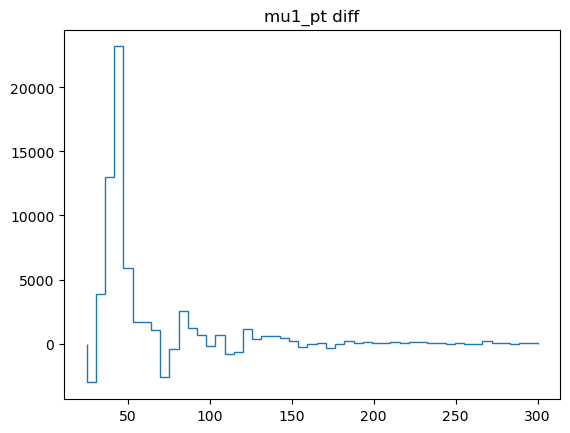

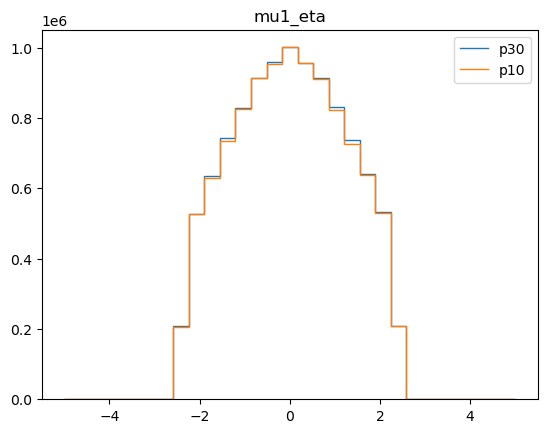

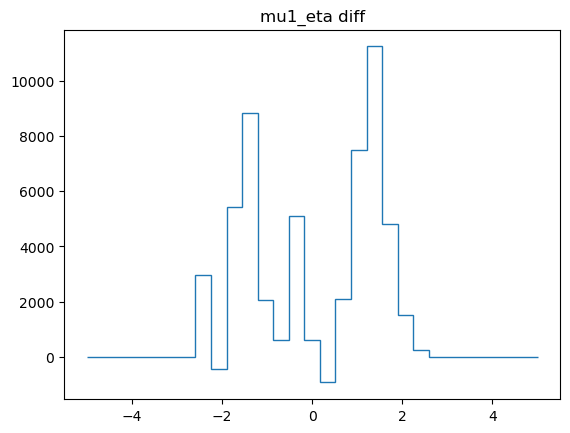

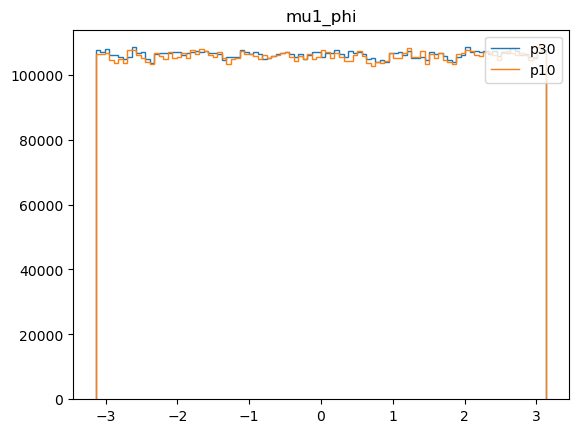

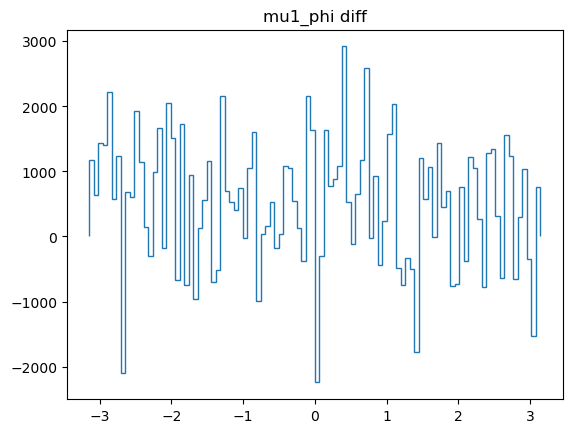

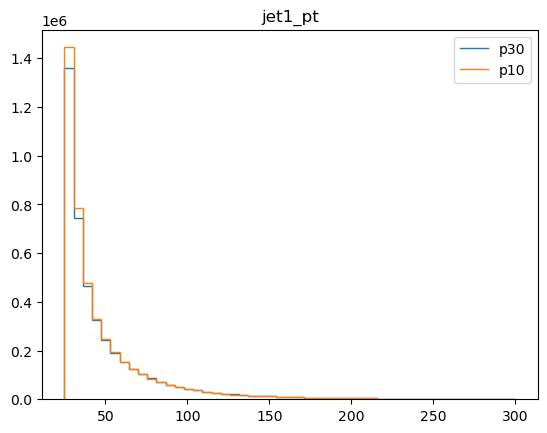

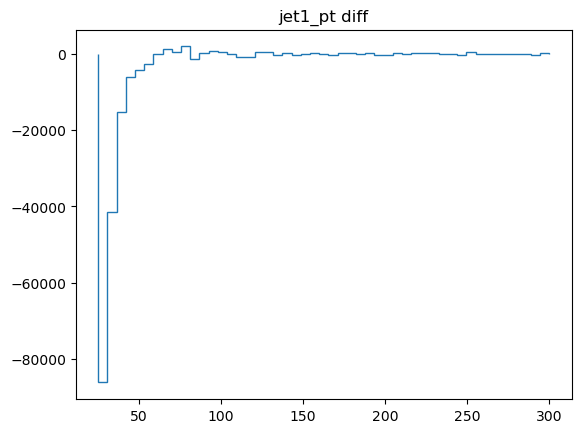

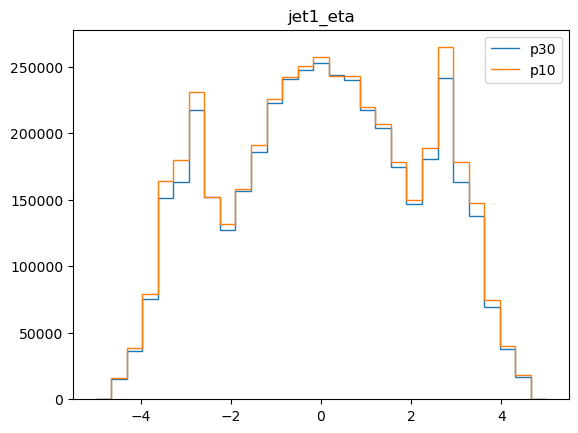

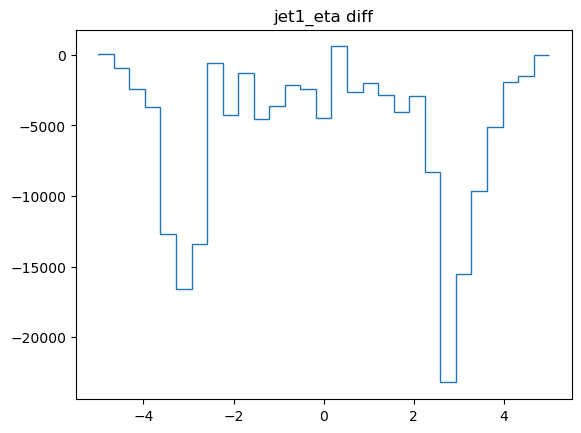

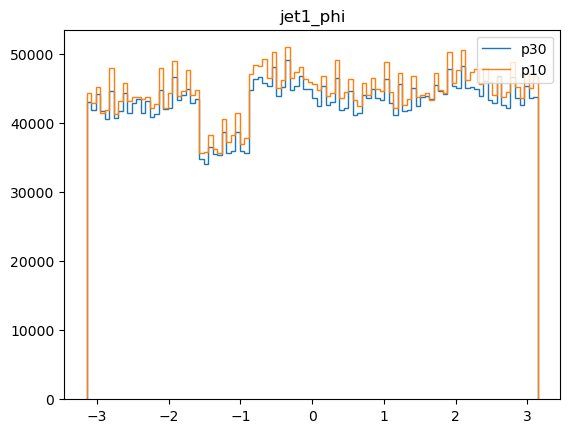

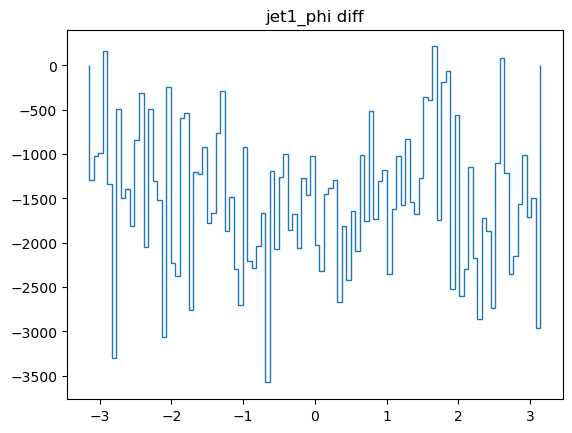

In [23]:
for var in variables:
    kin = var.split("_")[-1]
    # binning = np.linspace(*[25, 300, 50])
    binning = np.linspace(*binning_map[kin])
    # old_len = ak.num(df_old["mu1_pt"].compute(), axis=0)
    # new_len = ak.num(df_new["mu1_pt"].compute(), axis=0)
    # new_weights = np.ones(new_len)
    # new_weights = new_weights*old_len/new_len
    hist_new_p30, edges = np.histogram(df_new_p30[var].compute(), bins=binning ,weights=weights_new_p30)
    # hist_old, edges = np.histogram(df_old[var+"_nominal"].compute(), bins=binning )
    
    # hist_new, _= np.histogram(df_new[region_cut][var].compute(), bins=binning , weights=new_weights)
    hist_new_p10, _= np.histogram(df_new_p10[var].compute(), bins=binning ,weights=weights_new_p10)
    
    plt.stairs(hist_new_p30, edges, label = "p30")
    plt.stairs(hist_new_p10, edges, label = "p10")
    plt.legend(loc="upper right")
    plt.title(var)
    plt.show()
    plt.stairs((hist_new_p30-hist_new_p10), edges)
    plt.title(var+" diff")
    plt.show()

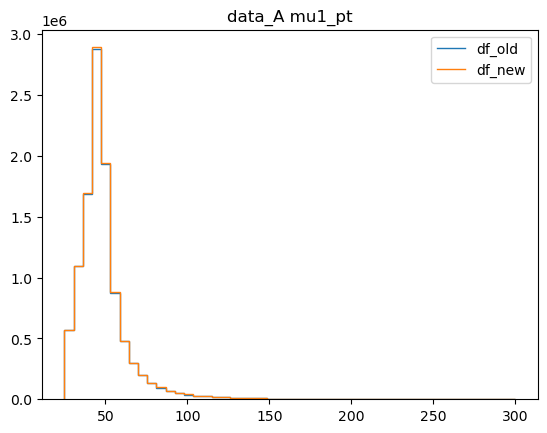

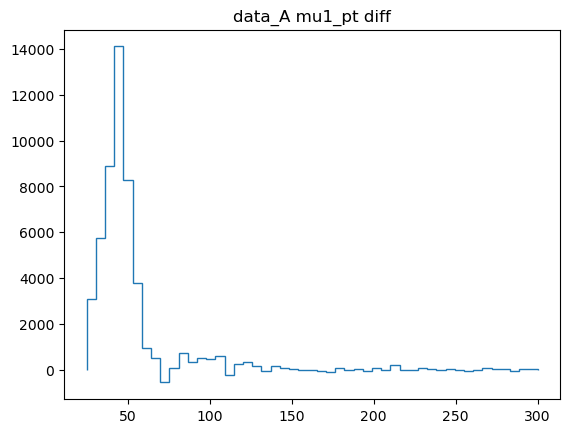

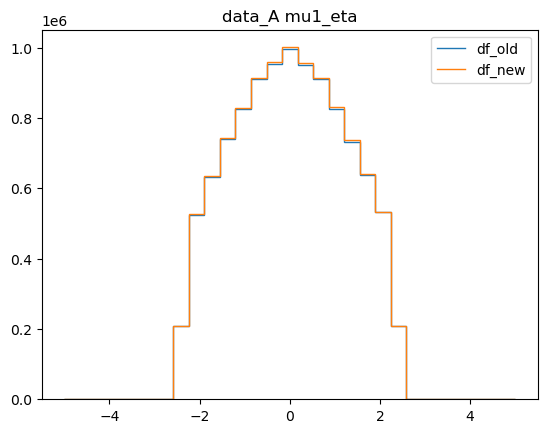

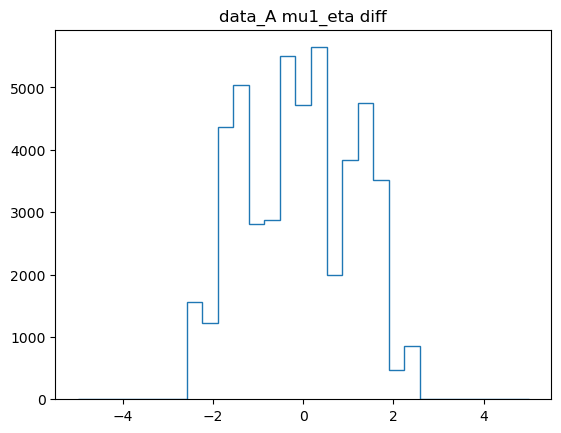

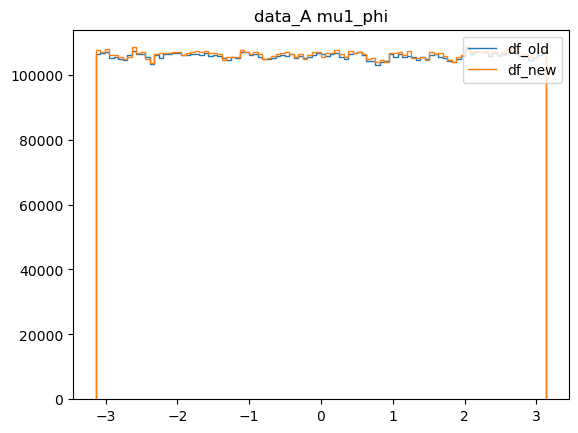

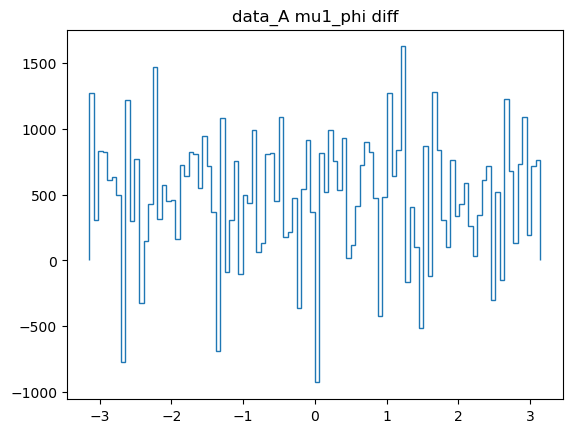

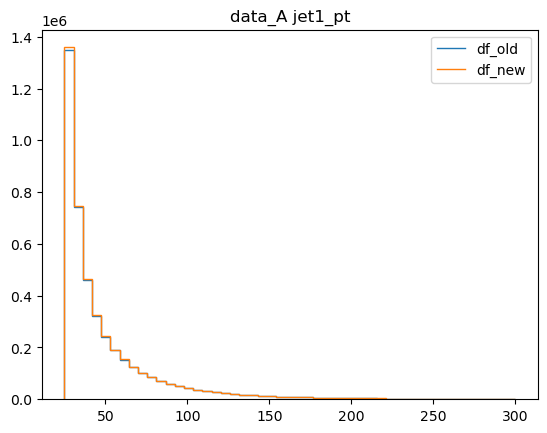

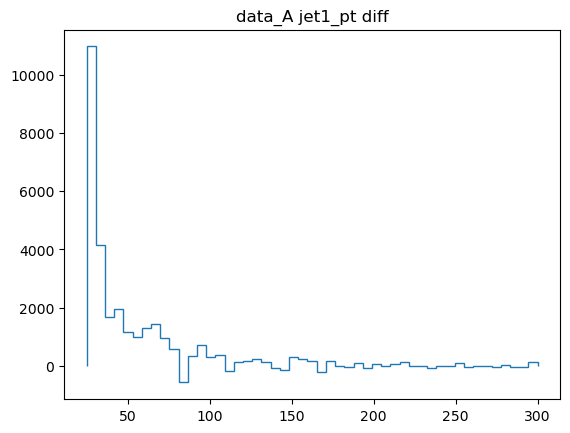

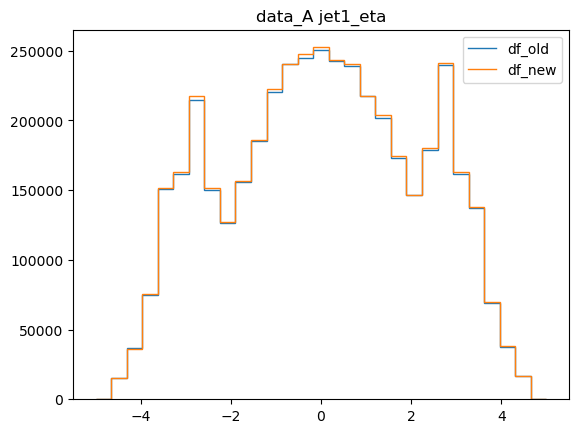

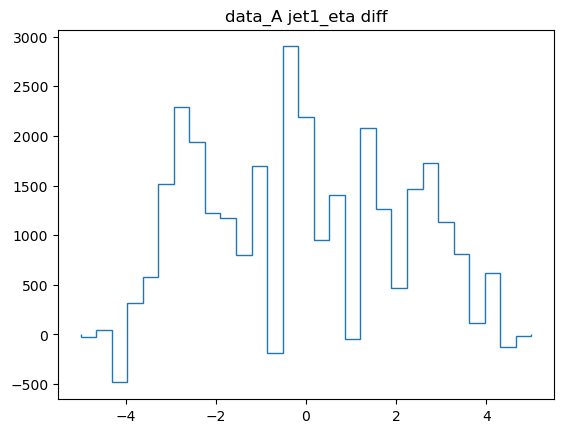

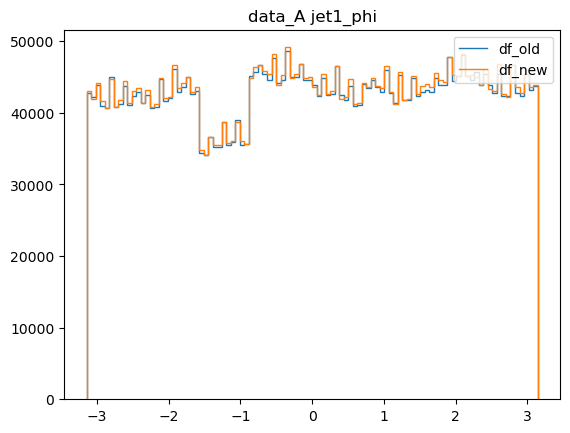

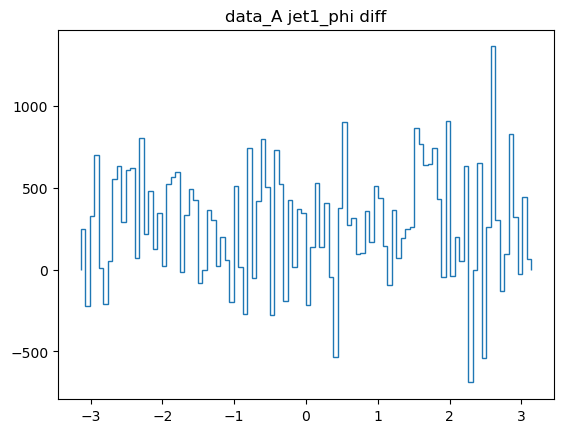

In [24]:
# sample = "vbf_powheg"
# sample = "ggh_powheg"
# sample = "dy_M-100To200"
sample = "data_A"
# full_load_path = f"/depot/cms/users/yun79/results/stage1/test_validation_bigV2/2018/f1_0/{sample}/*/*.parquet"
# full_load_path = f"/depot/cms/users/yun79/results/stage1/test_validation_bigV2/2018/f0_1/{sample}/*/*.parquet"
full_load_path = f"/depot/cms/users/yun79/results/stage1/test_validation_bigV2_2/2018/f0_2999999975166409/{sample}/*/*.parquet"

df_new = dak.from_parquet(full_load_path) 
# region_cut = (df_new.h_peak | df_new.h_sidebands)
# df_new = df_new[region_cut]
full_load_path = f"/depot/cms/users/yun79/hmm/test_validation_bigV1/stage1_output/2018/{sample}/*.parquet"
import dask.dataframe as dd
import pandas as pd
# df = dd.from_pandas(pd.DataFrame(), npartitions=1)
df_old = dd.read_parquet(full_load_path)
# region = df_old.region.compute()
binning_map = {
    "pt" : [25, 300, 50],
    "eta" : [-5, 5, 30],
    "phi" : [-3.1415, 3.1415, 101],
    "mass" : [0, 150, 100],
}
variables = ["mu1_pt","mu1_eta", "mu1_phi", 
             "jet1_pt", "jet1_eta", "jet1_phi"
            ]
weights_old = df_old["weights"].compute()
weights_new = ak.to_numpy((df_new["weights"]/df_new["fraction"]).compute())
if "ggh" in sample:
    print("ggh in sample!")
    nnlops_full_load_path = f'/depot/cms/users/yun79/results/stage1/test_full2/2018/f1_0/{sample}/*/nnlops/wgt.parquet'
    nnlops_wgts = ak.from_parquet(nnlops_full_load_path)["nnlops_wgt"]
    weights_new = weights_new*nnlops_wgts

for var in variables:
    kin = var.split("_")[-1]
    # binning = np.linspace(*[25, 300, 50])
    binning = np.linspace(*binning_map[kin])
    # old_len = ak.num(df_old["mu1_pt"].compute(), axis=0)
    # new_len = ak.num(df_new["mu1_pt"].compute(), axis=0)
    # new_weights = np.ones(new_len)
    # new_weights = new_weights*old_len/new_len
    hist_old, edges = np.histogram(df_old[var].compute(), bins=binning ,weights=weights_old)
    # hist_old, edges = np.histogram(df_old[var+"_nominal"].compute(), bins=binning )
    
    # hist_new, _= np.histogram(df_new[region_cut][var].compute(), bins=binning , weights=new_weights)
    hist_new, _= np.histogram(df_new[var].compute(), bins=binning ,weights=weights_new)
    
    plt.stairs(hist_old, edges, label = "df_old")
    plt.stairs(hist_new, edges, label = "df_new")
    plt.legend(loc="upper right")
    plt.title(f"{sample} {var}")
    plt.show()
    plt.stairs((hist_new-hist_old), edges)
    plt.title(f"{sample} {var}"+" diff")
    plt.show()

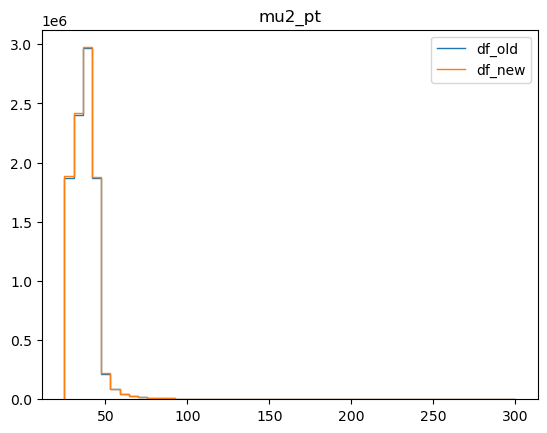

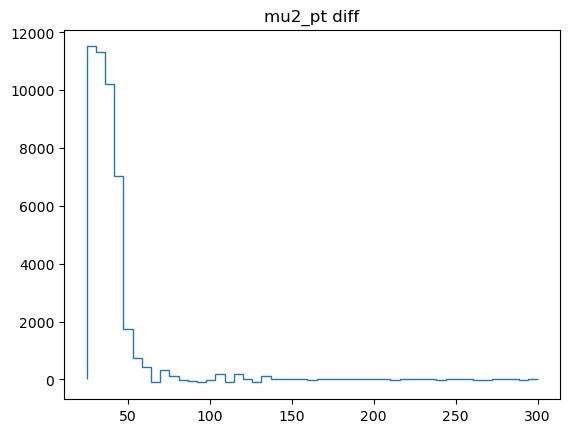

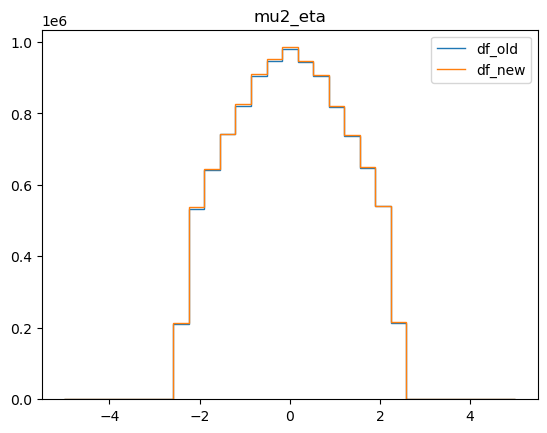

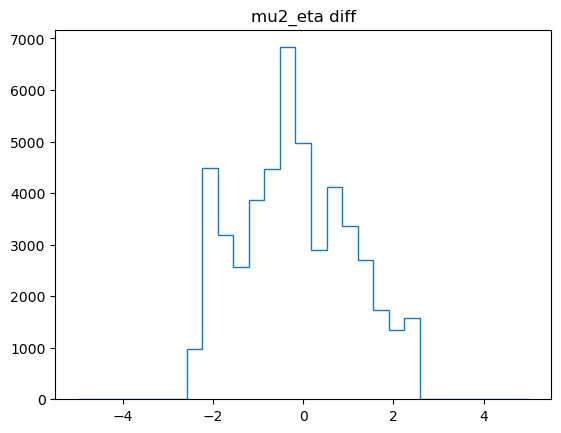

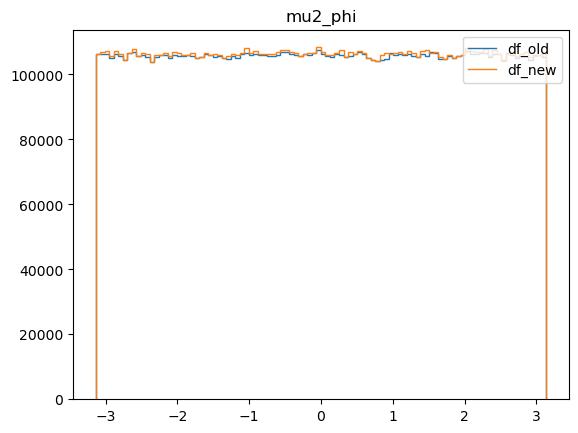

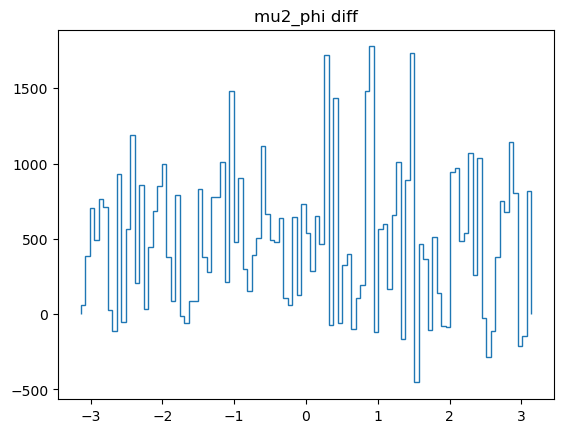

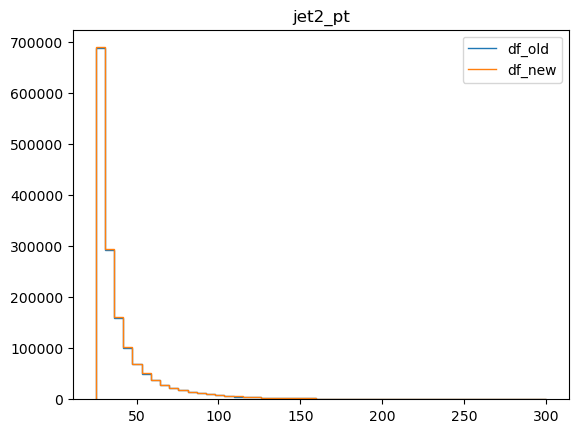

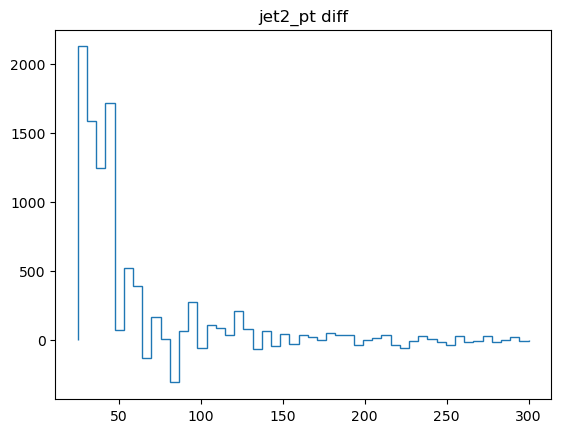

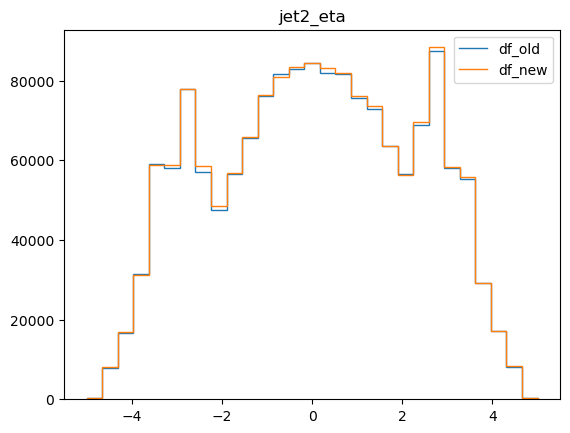

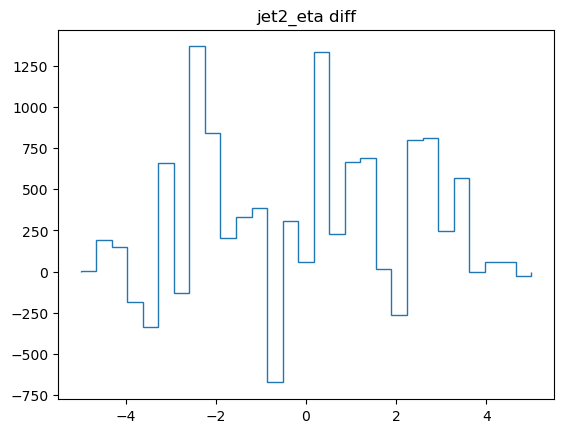

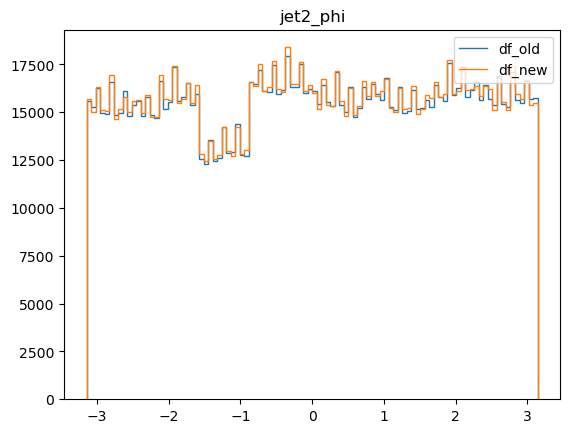

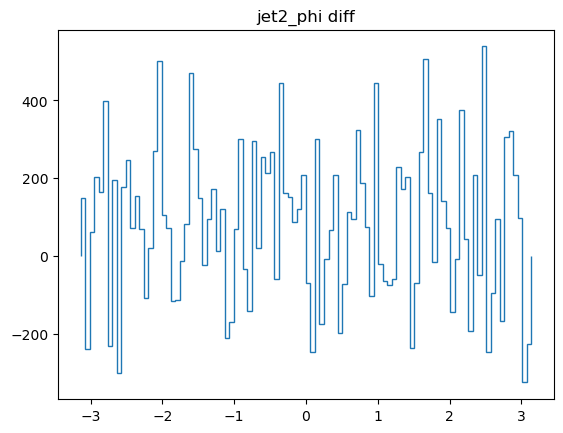

In [25]:
"""
For mu2, special condition is needed bc when there's only one muon, mu2==mu1 in copperhead
"""
# var = "mu1_pt"
# var = "dimuon_mass"
# var = "jet1_pt"
# variables = ["mu1_pt", "mu2_pt", "dimuon_mass"]
variables = ["mu2_pt","mu2_eta", "mu2_phi", 
             # "jet2_mass", 
             "jet2_pt", "jet2_eta", "jet2_phi"
            ]
    
for var in variables:
    kin = var.split("_")[-1]
    # binning = np.linspace(*[25, 300, 50])
    binning = np.linspace(*binning_map[kin])
    # the way copperheadV1 defines mu2 is the muon with the lowest pt, thus the
    # only way to make copperheadV1 and copperheadV2 same is to ensure nmuons ==2
    # if 'mu' in var:
    #     nvars_new = df_new["nmuons"].compute()
    #     nvars_old = df_old["nmuons"].compute()
    # else:
    #     nvars_new = df_new["njets"].compute()
    #     nvars_old = df_old["njets"].compute()
    # hist_old, edges = np.histogram(df_old[nvars_old ==2][var].compute(), bins=binning , weights=weights_old[nvars_old ==2])
    # hist_new, _= np.histogram(df_new[nvars_new ==2][var].compute(), bins=binning , weights=weights_new[nvars_new ==2])
    hist_old, edges = np.histogram(df_old[var].compute(), bins=binning , weights=weights_old)
    hist_new, _= np.histogram(df_new[var].compute(), bins=binning , weights=weights_new)
    
    
    plt.stairs(hist_old, edges, label = "df_old")
    plt.stairs(hist_new, edges, label = "df_new")
    plt.legend(loc="upper right")
    plt.title(var)
    plt.show()
    plt.stairs((hist_new-hist_old), edges)
    plt.title(var+" diff")
    plt.show()

In [1]:
import distributed
distributed.__version__

'2024.3.0'

In [2]:
import coffea
coffea.__version__

'2024.3.0'

In [18]:
! ls /depot/cms/users/yun79/results/stage1/test_validation_bigV2_2/2018/f0_2999999975166409/data_A/

0  1  2  3  4  5  6


In [9]:
# import os 
# import glob
# for i in range(7,27):
#     filelist=  glob.glob(f"/depot/cms/users/yun79/results/stage1/test_validation_bigV2/2018/f0_2999999975166409/data_A/{i}/*.parquet")
#     for file in filelist:
#             os.remove(file)


In [8]:
# filelist